# ESGF Virtual Aggregation - Demo

Remote data access to Virtual Analysis Ready Data (Virtual ARD) for climate datasets of the [ESGF](https://esgf.llnl.gov/).

## Contents

* [Introduction](#introduction)
  * [Loading the inventory](#loading-the-inventory)
  * [Loading a dataset](#loading-a-dataset)
  * [Query attributes](#query-attributes)
  * [Performing data analysis](#performing-data-analysis)
* [Similarities with other approaches](#similarities-with-other-approaches)
  * [Pangeo CMIP6](#pangeo-cmip6)
  * [Cloud native repositories](#cloud-native-repositories)
  * [ROOCS](#roocs) 
* [Discussion and FAQ](#discussion)

In [1]:
import timeit
import zipfile

import numpy as np
import pandas as pd
import netCDF4
import xarray
import dask
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

dask.config.set(scheduler="processes")

%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6

# Introduction <a class="anchor" id="introduction"></a>

## Loading the inventory <a class="anchor" id="loading-the-inventory"></a>

Currently, the invetory is a CSV file which can be queried for locating the desired dataset. You may also inspect the [THREDDS catalog](https://hub.ipcc.ifca.es/thredds/catalog/esgeva/catalog.html).

In [2]:
df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv")

# Find a dataset
subset = df.query("product == 'ScenarioMIP' & model == 'CNRM-CM6-1' & experiment == 'ssp245' & table == 'day' & variable == 'tas' & version == 'v20190410'")

# See available data nodes
subset[["location", "replica"]]

/tmp/ipykernel_269777/1605771671.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv")


,location,replica
2124279,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN
2124302,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,aims3.llnl.gov
2124321,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.ceda.ac.uk
2124329,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.nci.org.au
2124348,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf3.dkrz.de


Once you have located the desired URL for your dataset, save its URL.

In [3]:
# Select a data node and get the url
url = subset.query("replica.isnull()")["location"].iloc[0]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_gr_v20190410/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410.ncml'

## Loading a dataset <a class="anchor" id="loadingg-a-dataset"></a>

Now that you have an URL, try to load the dataset using [xarray](https://docs.xarray.dev/en/stable/).

In [4]:
# Use a demo URL for demonstration (see https://hub.ipcc.ifca.es/thredds/catalog/esgeva/demo/catalog.html)
url = "https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/demo/CMIP6_ScenarioMIP_MIROC_MIROC-ES2L_ssp245_3hr_tas_gn_v20210107_esgf-data02.diasjp.net.ncml"

# Load the URL
ds = xarray.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:           (lat: 64, bnds: 2, lon: 128, time: 251288,
                       variant_label: 29, nfiles: 2494, file: 2)
Coordinates:
  * lat               (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon               (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height            float64 ...
  * time              (time) datetime64[ns] 2015-01-01T03:00:00 ... 2101-01-01
  * variant_label     (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Dimensions without coordinates: bnds, nfiles, file
Data variables:
    lat_bnds          (lat, bnds) float64 ...
    lon_bnds          (lon, bnds) float64 ...
    further_info_url  (nfiles, file) |S64 ...
    tracking_id       (nfiles, file) |S64 ...
    tas               (variant_label, time, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:            
    activity_id:            ScenarioMIP
    branch_method:          no parent
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          
    ...                     ...
    size:                   2147483647
    size_human:             129.5 GiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    version:                v20210107
    replica:                0

### Query attributes <a class="anchor" id="query-attributes"></a>

The ESGF Virtual Aggregation includes metadata of interest for the users. Let's inspect some attributes.

In [5]:
# Query the size of the dataset on the server side (sum of file sizes on the server
ds.attrs["size_human"] # Note that this might be different from the size in memory

'129.5 GiB'

In [6]:
# View the variant_label (ensemble) coordinate
ds["variant_label"][...]

<xarray.DataArray 'variant_label' (variant_label: 29)>
array([b'r10i1p1f2', b'r11i1p1f2', b'r12i1p1f2', b'r13i1p1f2', b'r14i1p1f2',
       b'r15i1p1f2', b'r16i1p1f2', b'r17i1p1f2', b'r18i1p1f2', b'r19i1p1f2',
       b'r20i1p1f2', b'r21i1p1f2', b'r22i1p1f2', b'r23i1p1f2', b'r24i1p1f2',
       b'r25i1p1f2', b'r26i1p1f2', b'r27i1p1f2', b'r28i1p1f2', b'r29i1p1f2',
       b'r2i1p1f2', b'r30i1p1f2', b'r3i1p1f2', b'r4i1p1f2', b'r5i1p1f2',
       b'r6i1p1f2', b'r7i1p1f2', b'r8i1p1f2', b'r9i1p1f2'], dtype='|S64')
Coordinates:
    height         float64 ...
  * variant_label  (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Attributes:
    standard_name:        realization
    _CoordinateAxisType:  Ensemble

In [7]:
# Query the PID handles of the virtual dataset
ds["tracking_id"][:,1].values

array([b'hdl:21.14100/f79f6918-0a37-48c4-b30a-2c4ec9a4cb83',
       b'hdl:21.14100/971fe141-679e-4eb3-b196-7964ec6767f9',
       b'hdl:21.14100/b5ee8254-2b90-4c54-b044-07482009788f', ...,
       b'hdl:21.14100/94e4cf10-6dbf-4397-8fba-ac100d0b5435',
       b'hdl:21.14100/52d91e1d-8850-48a4-b2c0-4e89475dd5c9',
       b'hdl:21.14100/816e6917-15f5-4e83-9770-cad1679ba004'], dtype='|S64')

## Performing data analysis <a class="anchor" id="performing-data-analysis"></a>

Now that we have loaded the dataset, we can perform data analysis on it. First, let's chunk the dataset to allow scalability through [Dask]().

In [8]:
dsc = ds.chunk({"variant_label":1, "time": 100})

Now, inspect the structure of the data cube.

In [9]:
dsc["tas"]

<xarray.DataArray 'tas' (variant_label: 29, time: 251288, lat: 64, lon: 128)>
dask.array<xarray-tas, shape=(29, 251288, 64, 128), dtype=float32, chunksize=(1, 100, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon            (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height         float64 ...
  * time           (time) datetime64[ns] 2015-01-01T03:00:00 ... 2101-01-01
  * variant_label  (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Attributes:
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    long_name:        Near-Surface Air Temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: mean time: point
    cell_measures:    area: areacella
    history:          2020-11-28T05:25:09Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  64 128]

We are ready to perform data analysis of an small subset of the array and plot the results. Note that only the required data is transferred through the networking, involving no file downloads at all.

In [10]:
bins = [
    np.datetime64('2100-01-01'),
    np.datetime64('2100-03-15'),
    np.datetime64('2100-06-15'),
    np.datetime64('2100-09-15'),
    np.datetime64('2100-12-31')]
da = dsc["tas"].sel(variant_label=[b"r10i1p1f2", b"r11i1p1f2"], time=slice("21000101", None))

In [11]:
da

<xarray.DataArray 'tas' (variant_label: 2, time: 2921, lat: 64, lon: 128)>
dask.array<getitem, shape=(2, 2921, 64, 128), dtype=float32, chunksize=(1, 100, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon            (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height         float64 ...
  * time           (time) datetime64[ns] 2100-01-01 ... 2101-01-01
  * variant_label  (variant_label) |S64 b'r10i1p1f2' b'r11i1p1f2'
Attributes:
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    long_name:        Near-Surface Air Temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: mean time: point
    cell_measures:    area: areacella
    history:          2020-11-28T05:25:09Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  64 128]

In [12]:
%time results = da.groupby_bins("time", bins).mean().compute(nworkers=4)

CPU times: user 299 ms, sys: 65.3 ms, total: 364 ms
Wall time: 29.4 s


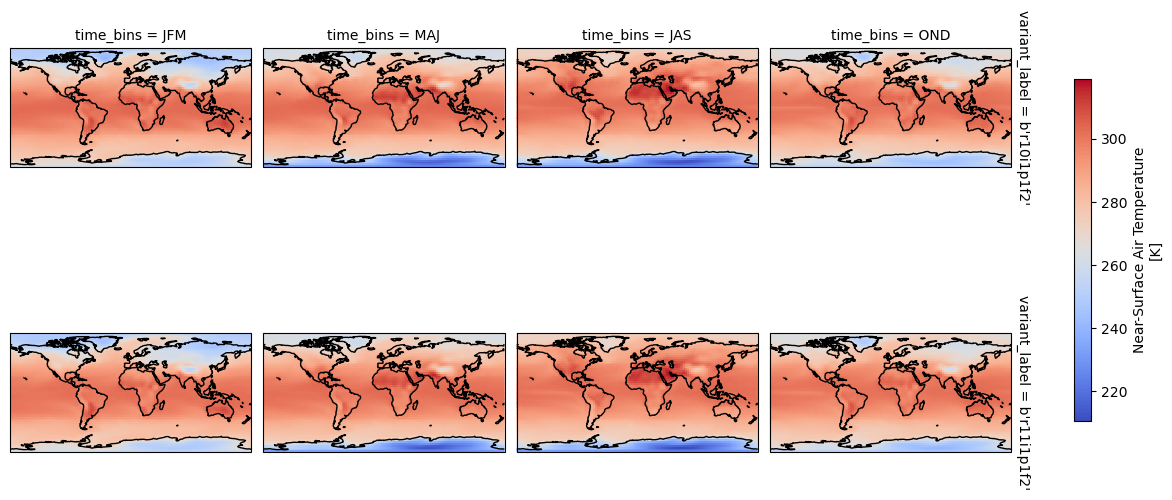

In [13]:
plot = results.assign_coords({"time_bins": ["JFM", "MAJ", "JAS", "OND"]}).plot(
    x="lon", y="lat", col="time_bins", row="variant_label",
    add_colorbar=True,
    cmap="coolwarm",
    cbar_kwargs={"shrink": .6},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

# Similarities with other approaches <a class="anchor" id="similarities-with-other-approaches"/>

Currently there is a strong emphasis in providing capabilities for easy data analysis of climate data, due to productivity that can be achieved. The ESGF Virtual Aggregation is one of these attemps and now we discuss how it compares to different approaches from the community.

## Pangeo CMIP6 <a class="anchor" id="pangeo-cmip6"/>

People from Pangeo are setting up cloud repositories for CMIP6 ARCO (Analysis Ready Cloud Optimized) datasets from ESGF. While the performance of these repositories is much superior to the data nodes of the ESGF, the cost of implementing these repositories is huge, due to the cost of duplicating the data. The ESGF Virtual Aggregation is less performant than cloud repositories but it is also much cheaper to build.

The ESGF Virtual Aggregation should be seen as an intermediate approach between the current state of the ESGF federation and more ground-breaking solutions like cloud repositories. Its main purpose is to show the compute capabilites that can be reached building on top of the existing federation.

[Here](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html) you can find the basic example for data search and load from the Pangeo repository. We try to reproduce this here using the ESGF Virtual Aggregation.

In [14]:
subset = df.query("product == 'CMIP' & model == 'CESM2' & experiment == 'historical' & table == 'Amon' & variable == 'tas' & version == 'v20190311'")
subset

,location,project,product,institution,model,experiment,subexperiment,table,variable,grid_label,version,replica
526416,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,NaN
526463,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,aims3.llnl.gov
526494,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,esgf-data04.diasjp.net
526534,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,esgf.ceda.ac.uk
526545,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,esgf.nci.org.au
526585,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,Amon,tas,gn,v20190311,esgf3.dkrz.de


In [15]:
url = subset.iloc[0]["location"]
ds = xarray.open_dataset(url).chunk({"time": 100})
ds

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:           (lat: 192, lon: 288, nbnd: 2, time: 1980,
                       variant_label: 3, nfiles: 12, file: 2)
Coordinates:
  * lat               (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time              (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * variant_label     (variant_label) |S64 b'r7i1p1f1' b'r8i1p1f1' b'r9i1p1f1'
Dimensions without coordinates: nbnd, nfiles, file
Data variables:
    lat_bnds          (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds          (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    time_bnds         (time, nbnd) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    further_info_url  (nfiles, file) |S64 dask.array<chunksize=(12, 2), meta=np.ndarray>
    tracking_id       (nfiles, file) |S64 dask.array<chunksize=(12, 2), meta=np.ndarray>
    tas               (variant_label, time, lat, lon) float32 dask.array<chunksize=(3, 100, 192, 288), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            
    activity_id:            CMIP
    case_id:                22
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.008
    contact:                cesm_cmip6@ucar.edu
    creation_date:          
    ...                     ...
    size_human:             695.7 MiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    cmor_version:           
    version:                v20190311
    replica:                0

Plot a map from a specific date.

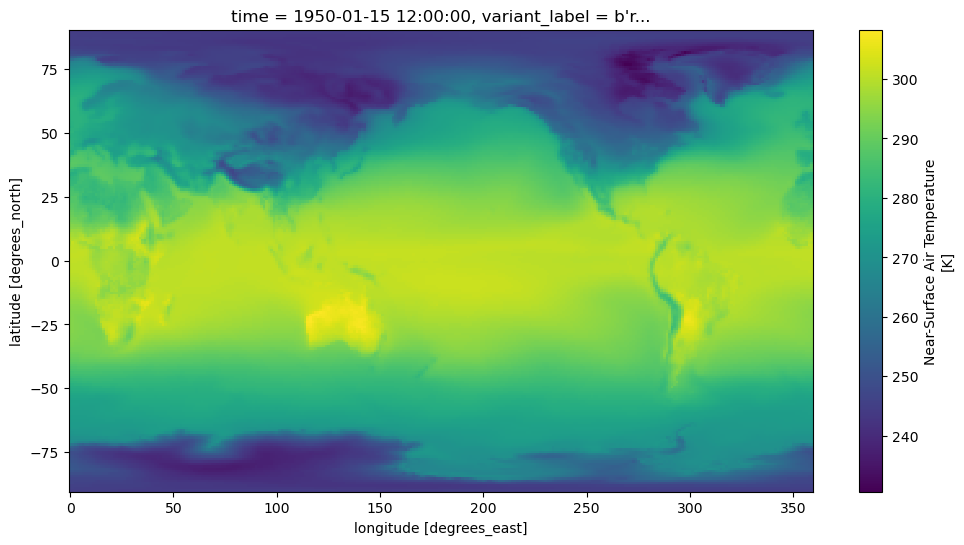

In [16]:
ds.tas.sel(time='1950-01', variant_label=b"r9i1p1f1").squeeze().plot()

Create a timeseries of global-average surface air temperature.

In [17]:
areacella = xarray.open_dataset("http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r9i1p1f1/fx/areacella/gn/v20190311/areacella_fx_CESM2_historical_r9i1p1f1_gn.nc")
areacella

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float32 ...
    lon_bnds   (lon, nbnd) float32 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                23
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.009
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-27T12:46:31Z
    ...                     ...
    variable_id:            areacella
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r9i1p1f1
    branch_time_in_parent:  295650.0
    branch_time_in_child:   674885.0
    branch_method:          standard

In [18]:
total_area = areacella["areacella"].sum(dim=["lon", "lat"])
ta_timeseries = (ds["tas"].sel(variant_label=b"r9i1p1f1") * areacella["areacella"]).sum(dim=["lon", "lat"]) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    variant_label  |S64 b'r9i1p1f1'

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [19]:
%time ta_timeseries.load()

CPU times: user 613 ms, sys: 1.44 s, total: 2.05 s
Wall time: 1min


<xarray.DataArray (time: 1980)>
array([285.6408 , 285.57397, 286.33856, ..., 288.6992 , 287.76303,
       287.0621 ], dtype=float32)
Coordinates:
  * time           (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    variant_label  |S64 b'r9i1p1f1'

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

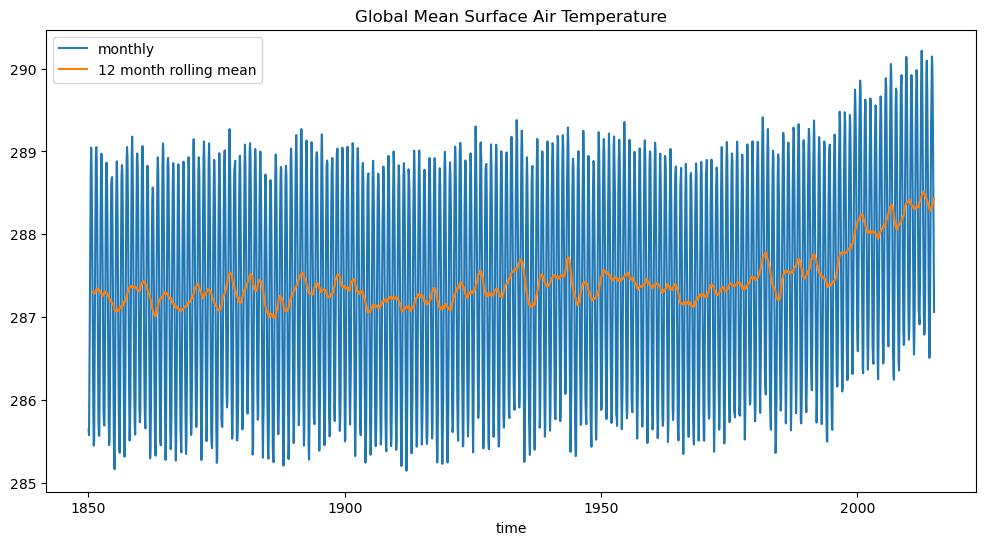

In [20]:
ta_timeseries.plot(label="monthly")
ta_timeseries.rolling(time=12).mean().plot(label="12 month rolling mean")
plt.legend()
plt.title("Global Mean Surface Air Temperature")

## Cloud native repositories <a class="anchor" id="cloud-native-repositories"/>

This work is a bridge between the current state of the federation and more elaborated [ETL](https://es.wikipedia.org/wiki/Extract,_transform_and_load) attemps such as [Google CMIP6](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html) from [Pangeo](https://pangeo.io/). The later is a much more expensive workflow that requires duplication of the datasets into a cloud provider, which in advantage offers much more scalable data service compared to the "best effort" basis of the ESGF data nodes. Also, the ESGF Virtual Aggregation offers a higher level Analysis Ready Dataset by adding the `ensemble` dimension to the variables (see the [Virtual Aggregation file](https://hub.ipcc.ifca.es/thredds/fileServer/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_gr_v20190410/replicas/aims3.llnl.gov/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410_aims3.llnl.gov.ncml)).

The ESGF Virtual Aggregation could act as an intermediate between the ESGF and cloud native repositories. Because ESGF Virtual Aggregation is much cheaper to run (since it only reads metadata from the ESGF distributed index), cloud repositories using cloud optimized formats (Zarr) can be created much easier. For example:

In [21]:
# Open a dataset from the ESGF Virtual Aggregation
ds = xarray.open_dataset("https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/demo/CMIP6_ScenarioMIP_MIROC_MIROC-ES2L_ssp245_3hr_tas_gn_v20210107_esgf-data02.diasjp.net.ncml").chunk({"variant_label": 1, "time": 736})

# Extract a subset from the ESGF Virtual Aggregation
subset = ds.sel(variant_label=[b"r10i1p1f2", b"r11i1p1f2", b"r12i1p1f2"], time=slice("21000601", "21000831"))
subset["tas"]

<xarray.DataArray 'tas' (variant_label: 3, time: 736, lat: 64, lon: 128)>
dask.array<getitem, shape=(3, 736, 64, 128), dtype=float32, chunksize=(1, 665, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon            (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height         float64 ...
  * time           (time) datetime64[ns] 2100-06-01 ... 2100-08-31T21:00:00
  * variant_label  (variant_label) |S64 b'r10i1p1f2' b'r11i1p1f2' b'r12i1p1f2'
Attributes:
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    long_name:        Near-Surface Air Temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: mean time: point
    cell_measures:    area: areacella
    history:          2020-11-28T05:25:09Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  64 128]

In [22]:
!rm -rf test.zarr

In [23]:
# Dump to a cloud native repository
subset.to_zarr("test.zarr")

## ROOCS <a class="anchor" id="roocs"/>

[ROOCS](https://github.com/roocs) is a project to develop data services in support of the Copernicus Climate Change Service (C3S). ROOCS is providing a collection of tools to provide data-aware processing services of climate projections from CMIP6, CMIP5 and CORDEX.

The main focus of the service is to reduce the volumes of data transferred by providing data-reduction processes that can be invoked directly from the C3S Climate Data Store (CDS).

[Here](https://nbviewer.org/github/roocs/rooki/blob/master/notebooks/demo/demo-rooki-concat-with-average-cmip6-decadal.ipynb) you can find an example of a ROOCS workflow. We try to reproduce the workflow here using the ESGF Virtual Aggregation.

In [24]:
# CMIP6.DCPP.MOHC.HadGEM3-GC31-MM.dcppA-hindcast.s1995-r1i1p1f2.Amon.tas.gn.v20200417
subset = df.query("product == 'DCPP' & model == 'HadGEM3-GC31-MM' & experiment == 'dcppA-hindcast' & subexperiment == 's1995' & table == 'Amon' & variable == 'tas' & version == 'v20200417'")
subset

,location,project,product,institution,model,experiment,subexperiment,table,variable,grid_label,version,replica
1134394,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,DCPP,MOHC,HadGEM3-GC31-MM,dcppA-hindcast,s1995,Amon,tas,gn,v20200417,NaN
1136223,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,DCPP,MOHC,HadGEM3-GC31-MM,dcppA-hindcast,s1995,Amon,tas,gn,v20200417,esgf-data1.llnl.gov
1137088,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,DCPP,MOHC,HadGEM3-GC31-MM,dcppA-hindcast,s1995,Amon,tas,gn,v20200417,esgf.nci.org.au


In [25]:
url = subset.query("replica == 'esgf.nci.org.au'").iloc[0]["location"]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/DCPP/Amon/CMIP6_DCPP_MOHC_HadGEM3-GC31-MM_dcppA-hindcast_Amon_gn_v20200417/replicas/esgf.nci.org.au/CMIP6_DCPP_MOHC_HadGEM3-GC31-MM_dcppA-hindcast_s1995_Amon_tas_gn_v20200417.ncml'

In [26]:
ds = xarray.open_dataset(url).chunk({"variant_label": 1, "time": 75})
ds["tas"]

<xarray.DataArray 'tas' (variant_label: 9, time: 125, lat: 324, lon: 432)>
dask.array<xarray-tas, shape=(9, 125, 324, 432), dtype=float32, chunksize=(1, 75, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -89.72 -89.17 -88.61 ... 88.61 89.17 89.72
  * lon            (lon) float64 0.4167 1.25 2.083 2.917 ... 357.9 358.7 359.6
    height         float64 ...
  * time           (time) object 1995-11-16 00:00:00 ... 2006-03-16 00:00:00
  * variant_label  (variant_label) |S64 b'r10i1p1f2' b'r1i1p1f2' ... b'r9i1p1f2'
Attributes:
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    long_name:        Near-Surface Air Temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2020-05-26T09:41:21Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1 324 432]

In [27]:
%time a = ds["tas"].mean(["lat", "lon"]).compute()

CPU times: user 26.1 ms, sys: 17.4 ms, total: 43.5 ms
Wall time: 7min 2s


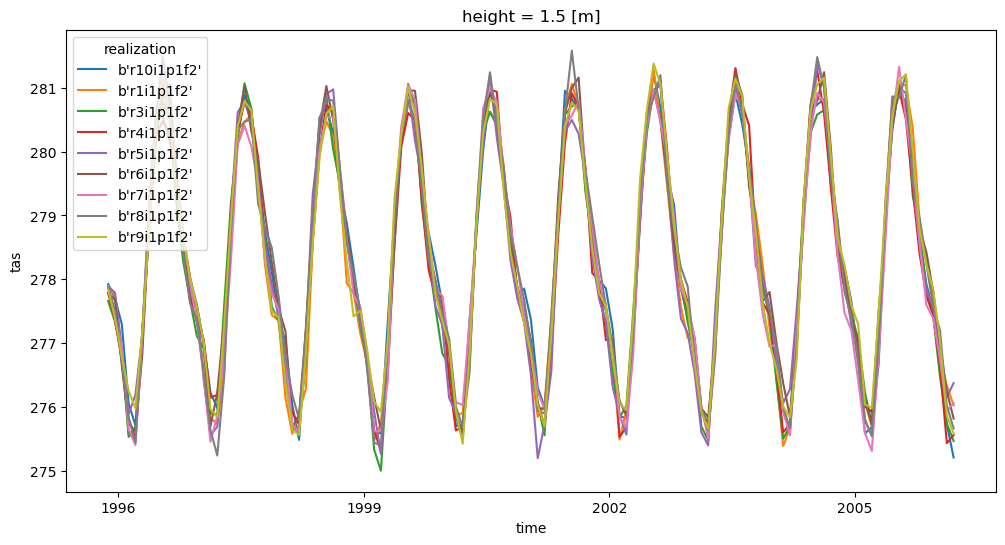

In [28]:
a.plot.line(x="time")

# Discussion <a class="anchor" id="discussion"></a>

## How it works?

**ALL** ESGF file metada is queried into a local database and from this database, small metadata [NcML]() files are created. The NcML files allow to merge multiple netCDF files into a single dataset. netCDF files from the federation are referenced by their OPeNDAP endpoint, thus no data movement is needed from the original data nodes.

```xml
<aggregation type="joinNew" dimName="variant_label">
    <variableAgg name="tas" />
        <netcdf coordValue="r2i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r2i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r2i1p1f2_gr_20150101-21001231.nc" ncoords="31411"/>
            </aggregation>
        </netcdf>
        <netcdf coordValue="r3i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r3i1p1f2_gr_20150101-21001231.nc" ncoords="31411"/>
            </aggregation>
        </netcdf>
</aggregation>
```

## Some ESGF Virtual Aggregation datasets, specially from the ensemble aggregation, take forever to open, why?

One of the main drawbacks of the current implementation of the ESGF Virtual Aggregation is that it takes a lot of time to open virtual datasets that reference lots (more than 100) files. Because no information is available in the ESGF index about the time coordinate, there is no way to tell the virtual dataset the size of the time dimension. Thus, the virtual dataset tries to obtain this from the files but this involves a huge amount of HTTP requests because it needs to query all the files in the virtual dataset. If only information about the size of the time dimension and the values from the time coordinate were available in the ESGF index, this performance issue would be solved.

## How does OPeNDAP compare to Zarr for remote data analysis?

In summary, Zarr is more efficient for remote data analysis. When requesting a piece of data from a Zarr store, the chunks travel compressed to the client. On the other hand, OPeNDAP servers uncompress the chunks from netCDF files on the server and send the data uncompressed to the client, making the transfer more inefficient.

## How does OPeNDAP compare to server side computing (eg: ROOCS)?

Both OPeNDAP and cloud native data stores aim to provide remote data analysis capabilities. Because the data is required to travel through the Internet, I/O performance is far from ideal. Server side computing such as ROOCS receive the compute request on the server and compute the result near to the data with much faster I/O. In general, remote data analysis serves for exploratory tasks and if fast I/O is needed, compute resources should be bought/requested in the infrastructure where the data resides.

## How does NcML compare to Kerchunk?

While Kerchunk focuses on creating a metada file to locate chunks of data in different formats, it can be use to create virtual datasets too (see [this](https://fsspec.github.io/kerchunk/tutorial.html#combine-multiple-kerchunked-datasets-into-a-single-logical-aggregate-dataset)). NcML serves a similar purpose but it works with CDM compatible datasets (see [netCDF-java CDM](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/common_data_model_overview.html)).

## Does OPeNDAP scale?

OPeNDAP is provided by the [THREDDS Data Server]() in ESGF data nodes. The TDS is a java web application and its ability to scale is the same as any other java web application. If deployed in a single application server, scalibility is limited to the single machine. If a kubernetes clustes is available to spawm multiple application servers, then it can scale and provide more performance.

## How are netCDF files distributed between NcMLs?

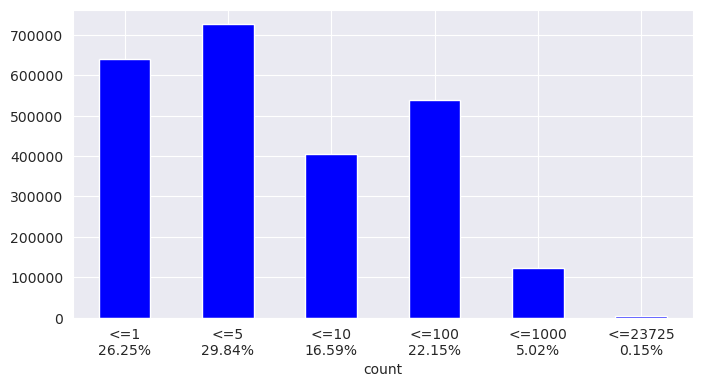

In [29]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(8, 4))

    with zipfile.ZipFile("ncml_dist.csv.zip", "r") as zip_file:
        df = pd.read_csv(zip_file.namelist()[0], names=["name", "count"], skiprows=1)

    bins = [0, 1, 5, 10, 100, 1000, df["count"].max()]
    cuts = pd.cut(df["count"], bins=bins).value_counts(sort=False)
    cuts.plot.bar(rot=0, color="b", ax=ax)
    ax.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(df)*100,2)) for c,v in zip(cuts.index.categories, cuts.values)])

## Why is the time variable a problem in ESGF?

In HDF5, chunks are stored in a B-Tree and very small values make the B-Tree unnecessary large. NetCDF files in ESGF usually use a chunk size of (1,) for the time coordinate.

Text(0.5, 1.0, 'Load time for sizes [256, 512, 1024, 2048, 4096, 8192]')

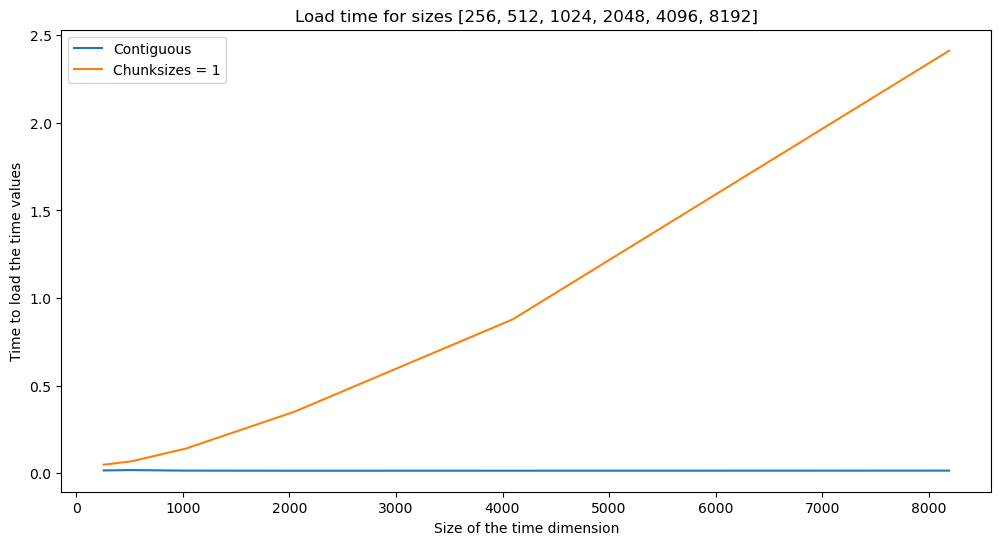

In [30]:
sizes = [256, 512, 1024, 2048, 4096, 8192]
results = []

def test(dset):
    return dset[...].mean()

for size in sizes:
    with netCDF4.Dataset("test.nc", "w") as f:
        f.createDimension("time", size)
        f.createVariable("time1", "f8", ("time",))
        f.createVariable("time2", "f8", ("time",), chunksizes=(1,))

        f["time1"][...] = list(range(size))
        f["time2"][...] = list(range(size))

    with netCDF4.Dataset("test.nc", "r") as f:
        results.append(timeit.timeit(lambda : test(f["time1"]), number=100))
        results.append(timeit.timeit(lambda : test(f["time2"]), number=100))

plt.plot(sizes, results[0::2], label="Contiguous")
plt.plot(sizes, results[1::2], label="Chunksizes = 1")
plt.legend()
plt.xlabel("Size of the time dimension")
plt.ylabel("Time to load the time values")
plt.title("Load time for sizes [256, 512, 1024, 2048, 4096, 8192]")